In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd
import imageio

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [26]:
configs_settings = [
    {"name": "full",
     "cfg": {
         "training": {
            "semantic_dis_lam": 0,
            "img_sym_num_azim": 5,
            "img_sym_lam": 200,
            "sil_lam": 10,
            "vertex_sym_lam": 1,
            "l2_lam": 10,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         },
        "refinement":{
            "num_iterations": 1000
        }
     }},
   
    {"name": "sil_only",
     "cfg": {
         "training": {
            "semantic_dis_lam": 0,
            "img_sym_num_azim": 0,
            "img_sym_lam": 0,
            "sil_lam": 10,
            "vertex_sym_lam": 0.0,
            "l2_lam": 0,
            "lap_smoothness_lam": 0,
            "normal_consistency_lam": 0
         }
     }},
    
    {"name": "sil",
     "cfg": {
         "training": {
            "semantic_dis_lam": 0,
            "img_sym_num_azim": 0,
            "img_sym_lam": 0,
            "sil_lam": 10,
            "vertex_sym_lam": 0.0,
            "l2_lam": 10,
            "lap_smoothness_lam": 0,
            "normal_consistency_lam": 0
         }
     }},
    
    {"name": "sil_smooth",
     "cfg": {
         "training": {
            "semantic_dis_lam": 0,
            "img_sym_num_azim": 0,
            "img_sym_lam": 0,
            "sil_lam": 10,
            "vertex_sym_lam": 0.0,
            "l2_lam": 10,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         }
     }},
    
    {"name": "sil_smooth_v_sym",
     "cfg": {
         "training": {
            "semantic_dis_lam": 0,
            "img_sym_num_azim": 3,
            "img_sym_lam": 0,
            "sil_lam": 10,
            "vertex_sym_lam": 1,
            "l2_lam": 10,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         },
        "refinement":{
            "num_iterations": 1000
        }

     }},    
    
    {"name": "sil_smooth_i_sym",
     "cfg": {
         "training": {
            "semantic_dis_lam": 0,
            "img_sym_num_azim": 5,
            "img_sym_lam": 200,
            "sil_lam": 10,
            "vertex_sym_lam": 0.0,
            "l2_lam": 10,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         }
     }}, 
    
]

In [5]:
# pix3d occnet gt
dataset = "shapenet"
class_name = "02691156"
instance = "de5807cb73bcbbf18587e940b916a22f"
cfg_path = "configs/final_refinement_params.yaml"


if dataset == "pix3d":
    rec_dir_name = "pix3d"
    img_dir_name = "pix3d_images_processed_filtered"
else:
    rec_dir_name = "pytorch3d_renders"
    img_dir_name = "pytorch3d_shapenet_renders"
input_img_dir = "data/input_images/{}/{}/rgba".format(img_dir_name, class_name)
input_img_path = os.path.join(input_img_dir, "{}.png".format(instance))
input_mesh_path = "/home/svcl-oowl/brandon/research/occupancy_networks/out/{}/{}/generation/meshes/{}.obj".format(rec_dir_name, class_name, instance)
gt_pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))[instance]
device = torch.device("cuda:0")

print(input_img_path)
print(input_mesh_path)
pprint.pprint(gt_pose_dict)

data/input_images/pytorch3d_shapenet_renders/02691156/rgba/de5807cb73bcbbf18587e940b916a22f.png
/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/02691156/generation/meshes/de5807cb73bcbbf18587e940b916a22f.obj
{'azim': 188.92770385742188, 'dist': 1.0, 'elev': 40.0}


full


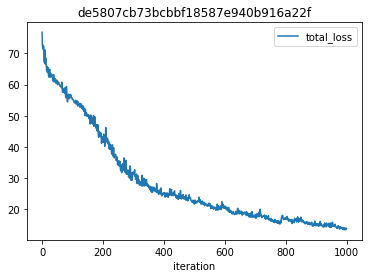

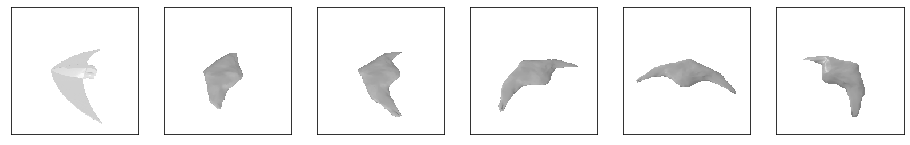

In [27]:
input_image = np.asarray(Image.open(input_img_path))
mask = np.asarray(input_image)[:,:,3] > 0
with torch.no_grad():
    input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
elev = gt_pose_dict["elev"]
azim = gt_pose_dict["azim"]
_, _, dist, _, _ = brute_force_estimate_dist(input_mesh, mask, azim, elev, 40, device)

#cfgs_to_use = ["sil_only", sil", "sil_smooth", "sil_smooth_i_sym", sil_smooth_v_sym, "full"]
cfgs_to_use = ["full"]

for config_setting in configs_settings:
    config_name = config_setting["name"]
    if config_name in cfgs_to_use:
        print(config_name)
        cfg = utils.load_config_dict(config_setting["cfg"], "configs/default.yaml")
        with torch.no_grad():
            input_mesh = utils.load_untextured_mesh(input_mesh_path, device)

        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))

        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)

        print("===========================================================================================")